In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from datetime import datetime, timedelta

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Project Description

Traffic scenario classification can be used in multiple service scenarios to accurately optimize network parameters or take different management and control measures based on the specific scenario. For example, in intelligent operation and maintenance, different fault types can be identified based on the traffic performance caused by each fault. In intelligent congestion control, rate control parameters can be configured based on traffic performance to ensure high throughput, low delay, and no packet loss. However, the status parameters of traffic in different scenarios may not differ significantly due to limitations in the collection device. Moreover, the number of scenarios within a given duration is uncertain, and random switching between scenarios can make it difficult to identify them. In some real-time decision situations, a response time of milliseconds or even microseconds may be required, which presents a greater challenge in solving the problem.

During transmission and forwarding processes, network traffic may be sent to the same port queue by multiple ports. As the output rate of the forwarding device is limited by the port bottleneck bandwidth, the input rate of traffic is higher than the output rate, resulting in the need for the forwarding device to allocate cache space to store burst traffic. This creates a cache queue at the egress port of the forwarding device. The queue length in the cache queue changes based on different types of forwarding traffic.

Currently, some status parameters, such as input rate (v_in), output rate (v_out), real-time length of the cache queue (q), and corresponding time (t), are collected at fixed time intervals. The output rate (v_out) is limited by the port bottleneck rate (v_max) where v_out <= v_max, while the input rate is affected by the burst and regulation protocol. So the maximum of input rate may be higher than the bottleneck rate. Here, the input and output rates are measured by the amount of traffic received and sent during each fixed time interval.

## Problem Statement

The objective of this challenge is to build a model based on the training set data to predict the traffic scenario for unknown traffic at each moment.Note: In this context, "unknown scenario" refers to a scenario with known traffic but unclear which of the known scenarios it belongs to, rather than a completely new scenario that has never occurred before.



# Import,Clean And Explore Data

There are 77 train dataset for the project , Lets take a look at 1 dataset

In [ ]:
first_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/Train_data/Train1.csv')

In [ ]:
#First four entry in the dataset
first_df.head()

,time,portPktIn,portPktOut,qSize,label
0,0,0.0,0.0,0,2
1,1,0.0,0.0,0,2
2,2,80184.0,80184.0,0,2
3,3,167045.0,167045.0,0,2
4,4,1970.0,1970.0,0,2


Ther are four feature variables in the dataset

time: Interval relative to the first flow sending time. Unit: Milliseconds.

portPktIn: Input rate of the cache queue. Here, we use the bytes of data received within the fixed interval of two adjacent points to represent the rate. Unit: Byte

portPktOut: Output rate of the cache queue. Here, we use the bytes of output data within the fixed interval of two adjacent points to represent the rate. Unit: Byte

qSizes: Length of the cache queue, where the length is a instantaneous value at the data collection moment. Unit: Byte

And our target variable

label: Scenario type ID, range: 0 – 11.


In [ ]:
print(first_df.shape)

# Checking for Missing values
first_df.isnull().sum()

(134000, 5)


time          0
portPktIn     0
portPktOut    0
qSize         0
label         0
dtype: int64

In [ ]:
#Descriptive Statistic of first_df
pd.options.display.float_format =  "{:.2f}".format #Convert Scientifi Notations to numerical
first_df.describe()

,time,portPktIn,portPktOut,qSize,label
count,134000.00,134000.00,134000.00,134000.00,134000.00
mean,66999.50,919952.38,919952.38,77122.23,5.53
std,38682.61,499995.37,497846.24,292209.16,3.40
min,0.00,0.00,0.00,0.00,0.00
25%,33499.75,556071.75,557246.75,0.00,3.00
50%,66999.50,1217300.00,1249057.00,10360.00,5.00
75%,100499.25,1250452.00,1249416.00,51800.00,8.00
max,133999.00,2318367.00,1250731.00,3446715.00,11.00


From the description , All the columns in the dataset except for the target variable (label column) are continuous numeracal values.The label column is a categerorical variable.

The entire dataset is spread across 133999 milliseconds of time(+ 0milliseconds),which means the entire data is collected based on a specific period of time.

Lets check the distribution of the columns

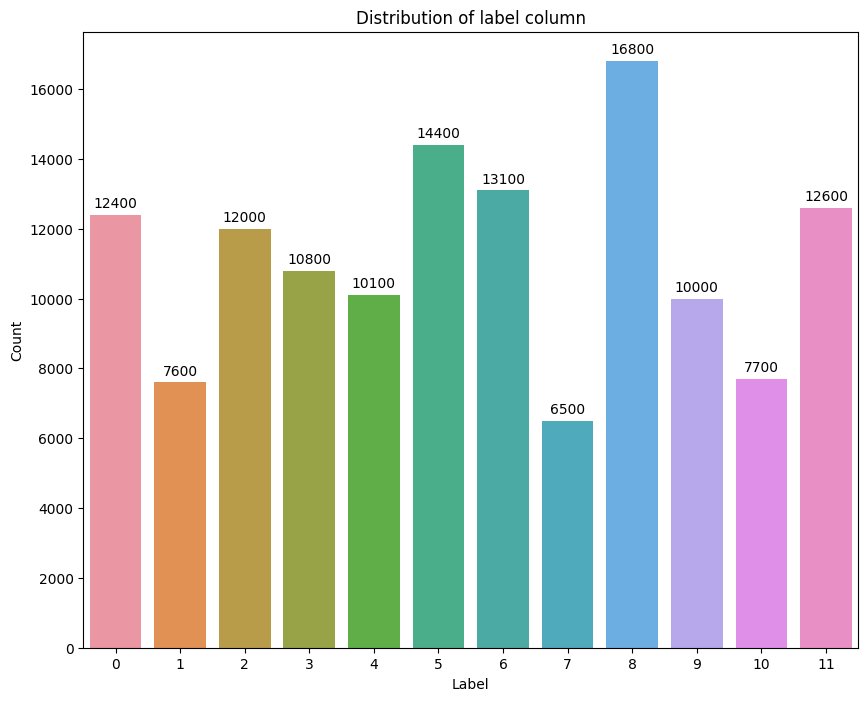

In [ ]:
# Creating a bar chart using seaborn
plt.figure(figsize=(10, 8))
count_data = first_df["label"].value_counts().sort_index()
ax = sns.barplot(x=count_data.index, y=count_data.values)

plt.title('Distribution of label column')
plt.xlabel('Label')
plt.ylabel('Count')

# Add data labels to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Add interactivity with tooltips using matplotlib
def on_bar_hover(event):
    for p in ax.patches:
        if p.contains(event)[0]:
            label = p.get_height()
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            plt.gca().annotate(f'Label: {int(label)}', (x, y), xytext=(0, 10),
                               textcoords='offset points', ha='center', fontsize=10, color='black')
            plt.gca().annotate(f'Count: {int(y)}', (x, y), xytext=(0, -18),
                               textcoords='offset points', ha='center', fontsize=10, color='black')

plt.gcf().canvas.mpl_connect('motion_notify_event', on_bar_hover)

plt.show()


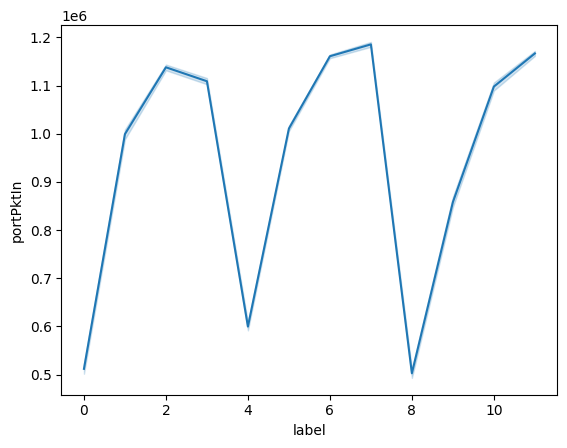

In [ ]:
 sns.lineplot(data= first_df,x='label', y = 'portPktIn')

plt.show()

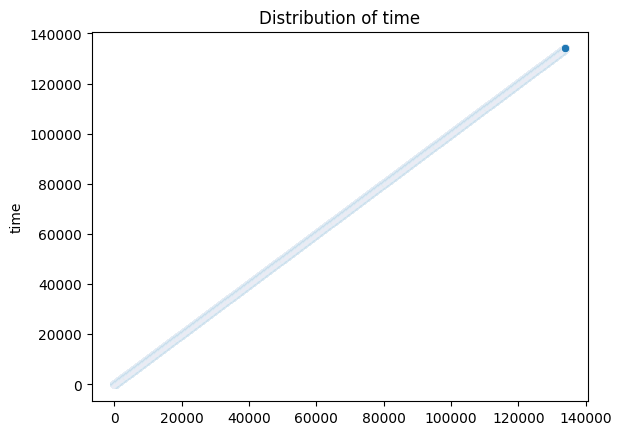

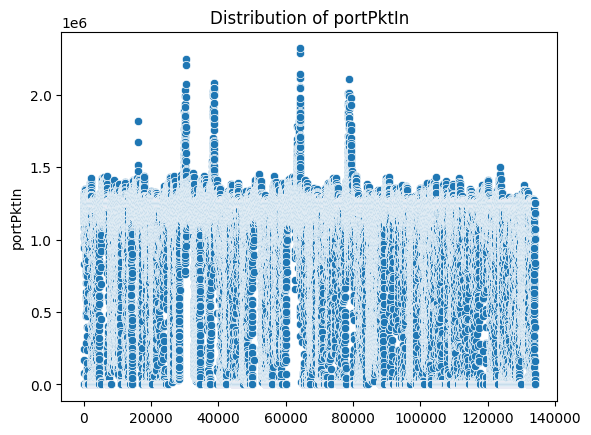

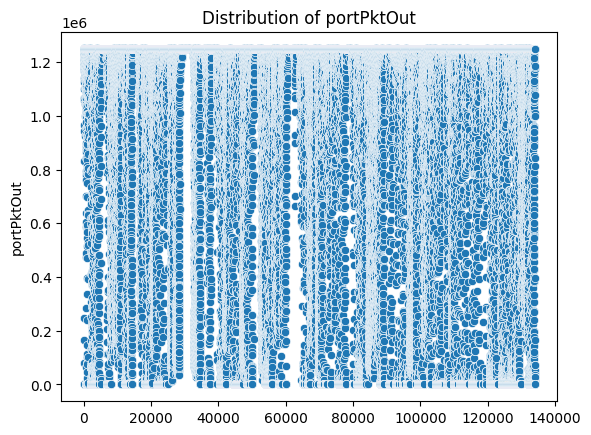

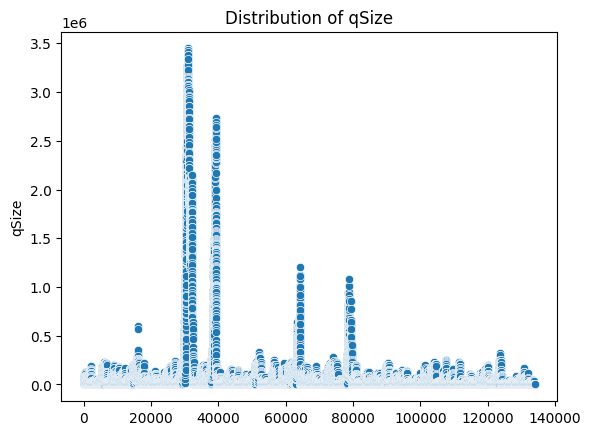

In [ ]:
col = ["time", "portPktIn", "portPktOut" ,"qSize"]

for cd in col:
  sns.scatterplot(first_df[cd])
  plt.title(f"Distribution of {cd}")
  plt.show()

From the distribution of each feature , it can be seen that the distribution of all feature except time is rough. From the plot ,

From 30,000 to 80, 000 it can be seen that at several occasion , there is a sharp increase in the queue lenght(qsize) ,input cache(portPktIn)

Lets look into those entries.

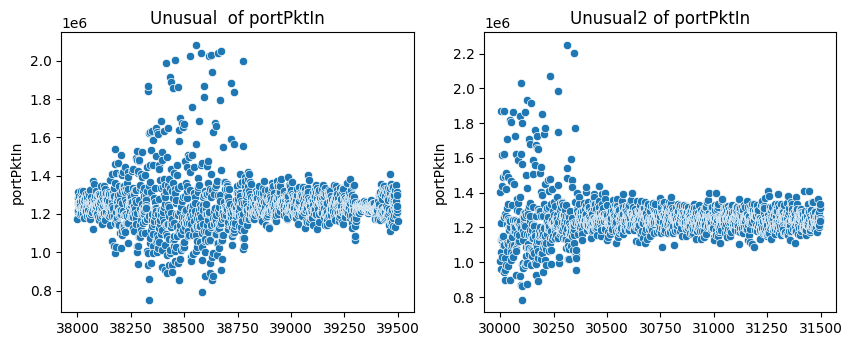

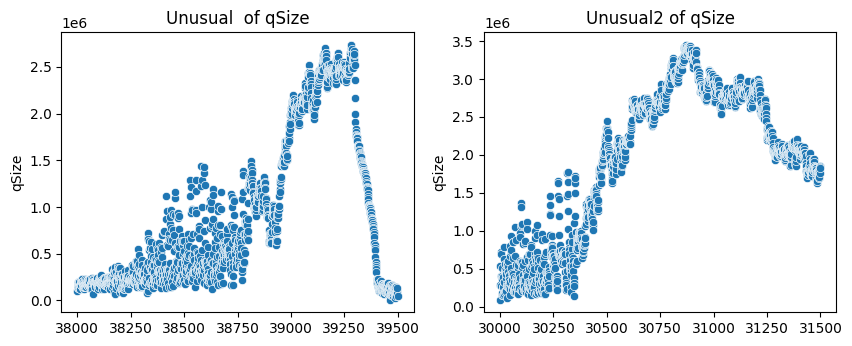

In [ ]:
#Checking for unusual behavior
anomaly = first_df[38000:39500]
anomaly1 = first_df[30000:31500]

col_ana = ["portPktIn" ,"qSize"]

for cd in col_ana:
  plt.figure(figsize=(10,8))
  plt.subplot(2,2,1)
  sns.scatterplot(anomaly[cd])
  plt.title(f"Unusual  of {cd}")

  plt.subplot(2,2,2)
  sns.scatterplot(anomaly1[cd])
  plt.title(f"Unusual2 of {cd}")

  plt.show()

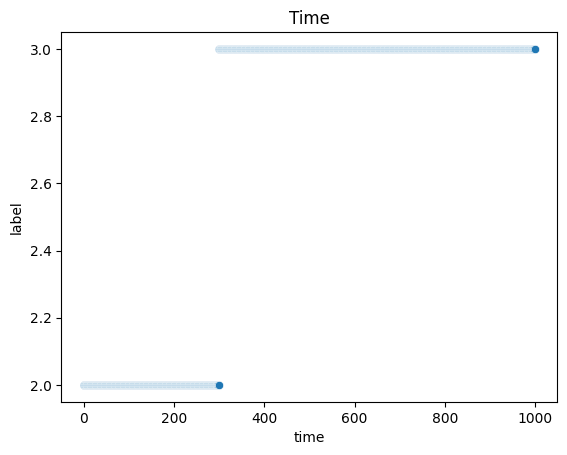

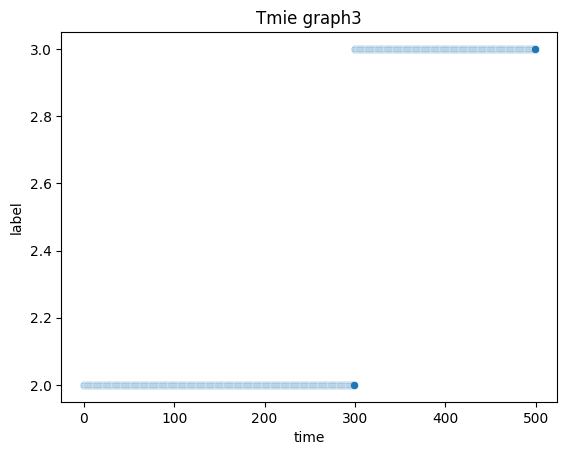

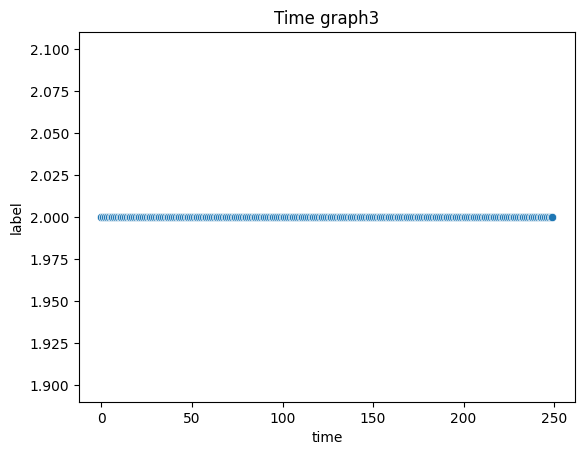

In [ ]:

time_constrain = first_df[:1000]
time_constrain2 = first_df[:500]
time_constrain3 = first_df[:250]



sns.scatterplot(data = time_constrain, x='time', y= 'label')
plt.title(f"Time")
plt.show()


sns.scatterplot(data= time_constrain2, x='time', y= 'label')
plt.title("Tmie graph3")
plt.show()

sns.scatterplot(data= time_constrain3, x='time', y= 'label')
plt.title("Time graph3")

plt.show()

,time,portPktIn,portPktOut,qSize,label
count,9300.00,9300.00,9300.00,9300.00,9300.00
mean,34649.50,1102699.16,1102486.73,618403.82,5.74
std,2684.82,353157.17,343432.38,917624.40,2.73
min,30000.00,0.00,0.00,0.00,2.00
25%,32324.75,1160320.00,1247344.00,17612.00,4.00
50%,34649.50,1229668.50,1249416.00,99456.00,6.00
75%,36974.25,1269100.00,1249864.25,1070864.75,7.00
max,39299.00,2249161.00,1250723.00,3446715.00,11.00


# Import for Data Processing

In [ ]:
import pandas as pd
import glob
import random

# Path to the folder containing training datasets
folder_path = r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/Train_data/'

# List of all filenames of datasets in the folder
all_files = glob.glob(folder_path + '*.csv')  # Modify if using a different file format

In [ ]:
# Number of times to repeat the process
num_repeats = 7

# Number of datasets to pick in each iteration
datasets_per_iteration = 11

# List to store concatenated datasets
concatenated_datasets_list = []

for _ in range(num_repeats):
    # Randomly shuffle the list of files
    random.shuffle(all_files)

    # Randomly select datasets
    selected_files = all_files[:datasets_per_iteration]

    # Load and concatenate selected datasets
    selected_datasets = [pd.read_csv(file_path) for file_path in selected_files]
    concatenated_df = pd.concat(selected_datasets, ignore_index=True)

    # Append the concatenated dataframe to the list
    concatenated_datasets_list.append(concatenated_df)

    # Remove selected files from the all_files list
    all_files = [file_path for file_path in all_files if file_path not in selected_files]



# Data Wrangling

In [ ]:
def wrangle(df):
    # Input rate vs. Output rate ratio
    df['input_output_ratio'] = df['portPktIn'] / df['portPktOut']

    # Convert milliseconds to seconds as integers
    df['Seconds'] = df['time'] // 1000

    df["prkttotal"] = df['portPktIn'] + df['portPktOut']

    # Input rate vs. Output rate ratio
    df['input_output_ratio'] = df['portPktIn'] / df['portPktOut']

    # Calculate the time interval between consecutive time points in seconds
    df['time_interval'] = df['time'].diff() / 1000  # Convert from milliseconds to seconds

    # Drop the intermediate columns if needed
  #  df.drop([ 'time_interval'], axis=1, inplace=True)


    df.fillna(0, inplace=True)

    return df

In [ ]:
training = []

for files in concatenated_datasets_list:
  files = wrangle(files)
  training.append(files)



In [ ]:
training

In [ ]:
from scipy import stats

def process_chunk(chunk):
    result = {
        'mean_time': chunk['time'].sum(),
        'Seconds' : chunk['Seconds'].mean(),
        'portPktIn': chunk['portPktIn'].mean(),
        'portPktOut': chunk['portPktOut'].mean(),
        'qSize': chunk['qSize'].mean(),
        'input_output_ratio': chunk['input_output_ratio'].mean(),
        "prkttotal" : chunk["prkttotal"].mean(),
        'label': stats.mode(chunk['label'])[0][0]
    }
    return result

chunk_size = 500
processed_data = []


for files in training:
  for i in range(0, len(files), chunk_size):
      chunk = files.iloc[i:i+chunk_size]
      if len(chunk) > 0:
          processed_data.append(process_chunk(chunk))

train = pd.DataFrame(processed_data)



<ipython-input-126-862dbd5891f0>:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  'label': stats.mode(chunk['label'])[0][0]


In [ ]:
    # Convert seconds to datetime
    #df['Datetime'] = pd.to_datetime(df['Seconds'], unit='s')

    # Extract and format seconds only
    train['Seconds_only'] = train['Datetime'].dt.strftime('%S')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19112 entries, 0 to 19111
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   mean_time           19112 non-null  int64         
 1   Seconds             19112 non-null  float64       
 2   portPktIn           19112 non-null  float64       
 3   portPktOut          19112 non-null  float64       
 4   qSize               19112 non-null  float64       
 5   input_output_ratio  19112 non-null  float64       
 6   prkttotal           19112 non-null  float64       
 7   label               19112 non-null  int64         
 8   Datetime            19112 non-null  datetime64[ns]
 9   Seconds_only        19112 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 1.5+ MB


In [ ]:
train.head(10)

,mean_time,Seconds,portPktIn,portPktOut,qSize,input_output_ratio,prkttotal,label,Datetime,Seconds_only
0,124750,0.00,794706.31,794704.23,6863.07,0.75,1589410.54,2,1970-01-01 00:00:00,00
1,374750,0.00,469935.82,469937.89,895.10,0.44,939873.71,8,1970-01-01 00:00:00,00
2,624750,1.00,565981.96,565981.96,5070.18,0.49,1131963.92,8,1970-01-01 00:00:01,01
3,874750,1.00,486696.09,486696.09,1591.30,0.43,973392.18,8,1970-01-01 00:00:01,01
4,1124750,2.00,539271.37,539271.37,1744.62,0.49,1078542.75,9,1970-01-01 00:00:02,02
5,1374750,2.00,711741.15,711571.24,7299.80,0.65,1423312.39,9,1970-01-01 00:00:02,02
6,1624750,3.00,989833.12,989791.68,25747.58,0.90,1979624.80,2,1970-01-01 00:00:03,03
7,1874750,3.00,1247836.06,1247875.43,87629.06,1.00,2495711.50,3,1970-01-01 00:00:03,03
8,2124750,4.00,691116.84,691288.82,19346.87,0.58,1382405.66,8,1970-01-01 00:00:04,04
9,2374750,4.00,909730.81,909730.81,3246.82,0.77,1819461.62,8,1970-01-01 00:00:04,04


In [ ]:
concatenated_datasets_list

In [ ]:
train = wrangle(train)

# Tesst Dataset Prepearation

In [ ]:
all_files

['/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/Train_data/Train14.csv']

In [ ]:
import pandas as pd
from scipy import stats

def process_and_aggregate(df, chunk_size):
    def process_chunk(chunk):
        result = {
             'mean_time': chunk['time'].sum(),
            'portPktIn': chunk['portPktIn'].mean(),
            'portPktOut': chunk['portPktOut'].mean(),
            'time_interval': chunk['time_interval'].mean(),
            'qSize': chunk['qSize'].mean(),
            'input_output_ratio': chunk['input_output_ratio'].mean(),
            "prkttotal" : chunk["prkttotal"].mean(),
            "prktdiff" : chunk["prktdiff"].mean(),
            "qsize_rate" : chunk['qsize_rate'].mean(),
            "input_rate" : chunk['input_rate'].mean(),
            "output_rate" : chunk['output_rate'].mean(),
            "queue_size_change" : chunk['queue_size_change'].mean(),
            "cumulative_input_rate" : chunk['cumulative_input_rate'].mean(),
            "cumulative_output_rate" : chunk['cumulative_output_rate'].mean(),
            "cumulative_rate_change  " : chunk['cumulative_rate_change'].mean(),
            'label': stats.mode(chunk['label'])[0][0]
            }
        return result

    processed_data = []

    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i+chunk_size]
        if len(chunk) > 0:
            processed_data.append(process_chunk(chunk))

    result_df = pd.DataFrame(processed_data)
    return result_df



In [ ]:
test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/Train_data/Train14.csv')





test = wrangle(test)



test = process_and_aggregate(test, 250)

<ipython-input-9-a13212014ff1>:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  'label': stats.mode(chunk['label'])[0][0]


In [ ]:
train.head()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
train.describe()

,mean_time,portPktIn,portPktOut,time_interval,qSize,input_output_ratio,prkttotal,prktdiff,qsize_rate,input_rate,output_rate,queue_size_change,cumulative_input_rate,cumulative_output_rate,cumulative_rate_change,label
count,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00,19104.00
mean,31389354.27,938660.66,938660.04,0.00,85979.57,0.86,1877320.70,0.62,3979324517.97,1.35,1.42,0.00,639355009156.51,639354515406.54,938658.86,5.58
std,18549426.59,269799.39,269786.36,0.02,360874.42,0.18,539585.34,670.32,2603796947.62,1295.17,1288.88,672.33,371044571806.11,371044343397.69,269798.62,3.45
min,124750.00,103125.90,103125.90,-0.30,0.00,0.14,206251.80,-13511.04,0.32,-3105.01,-2501.40,-13511.04,80631606.86,80630052.50,103125.90,0.00
25%,15624750.00,719878.93,719878.93,0.00,5464.86,0.77,1439757.85,-35.22,1710705892.41,-253.98,-125.66,-35.22,319011627960.87,319011502442.65,719878.93,3.00
50%,31124750.00,988922.93,988950.58,0.00,18724.17,0.95,1977883.95,0.00,4402827082.95,0.00,0.00,0.00,638074292771.55,638072594622.02,988922.93,6.00
75%,46624750.00,1190101.94,1190082.57,0.00,55211.43,1.00,2380256.02,45.58,5828430394.46,272.56,136.40,45.58,958691405856.67,958689164982.33,1190101.94,9.00
max,74374750.00,1257308.84,1249704.47,0.00,7824670.68,1.01,2507009.77,7607.90,14047924145.62,2917.07,2501.40,7607.90,1334764827217.17,1334764776289.09,1257308.84,11.00


In [ ]:
train = train[train["qSize"] < 1500000]

In [ ]:
test.describe()

In [ ]:
val = train.label.value_counts().sort_values()

In [ ]:
plt.figure(figsize=(10,8))
val.plot(kind="barh")

In [ ]:
pip install factor-analyzer

In [ ]:
from factor_analyzer import FactorAnalyzer


# Create a FactorAnalyzer instance
fa = FactorAnalyzer(n_factors=3, rotation='varimax')

# Fit the EFA model to your data
fa.fit(train)

# Get factor loadings
factor_loadings = fa.loadings_

In [ ]:
factor_loadings

array([[-0.1077477 , -0.0145569 ,  0.07842434],
       [ 0.99806373,  0.02940461, -0.01042374],
       [ 0.99806851,  0.02883037, -0.01039002],
       [ 0.00462503, -0.07034936,  0.00176216],
       [ 0.44866762, -0.01787051, -0.0123466 ],
       [ 0.76352617,  0.03505283, -0.01262455],
       [ 0.99806649,  0.02911751, -0.01040688],
       [ 0.02247546,  0.2266576 , -0.01387298],
       [-0.71027938, -0.02205983,  0.01287478],
       [ 0.01283317,  0.99025269,  0.02193515],
       [ 0.01480863,  0.95262171,  0.02113891],
       [ 0.02211256,  0.22443212, -0.01375274],
       [ 0.0254297 , -0.02213216,  0.99808608],
       [ 0.02542952, -0.02213216,  0.99808609],
       [ 0.99806374,  0.02939821, -0.01042129],
       [ 0.12545272,  0.00287291,  0.02062123]])

In [ ]:
trainX= train.copy()
testX= test.copy()

In [ ]:
trainX.head()

,mean_time,portPktIn,portPktOut,time_interval,qSize,input_output_ratio,prkttotal,prktdiff,qsize_rate,input_rate,output_rate,queue_size_change,cumulative_input_rate,cumulative_output_rate,cumulative_rate_change,label
0,124750,965928.95,965686.29,0.00,21144.90,1.00,1931615.24,242.65,5237944587.17,2272.45,2123.04,242.65,242751474.56,242730329.66,965552.89,5
1,374750,760325.69,760568.34,0.00,14459.57,1.00,1520894.03,-242.65,5237094639.85,-1525.93,-1376.51,-242.65,707057757.31,707043297.73,760325.69,4
2,624750,615612.58,615585.64,0.00,4671.86,1.00,1231198.22,26.94,5787671309.69,1207.03,1190.46,26.94,1025812814.64,1025808142.78,615612.58,4
3,874750,981062.72,980998.49,0.00,23645.60,1.00,1962061.20,64.23,3373158025.53,154.42,185.50,64.23,1381679082.60,1381655437.00,981062.72,2
4,1124750,922415.85,922507.02,0.00,16721.47,0.79,1844922.88,-91.17,2981069145.23,-2484.04,-2498.54,-91.17,1944491045.36,1944474323.89,922415.85,2


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with columns 0 through 5
# Replace df with your actual DataFrame

# Extract column names
column_names = trainX.drop("label", axis=1).columns

# Create a MinMaxScaler object
scaler = StandardScaler()

# Apply scaling while preserving column names
trainXs = pd.DataFrame(scaler.fit_transform(trainX.drop("label", axis=1)), columns=column_names)
testXs = pd.DataFrame(scaler.fit_transform(testX.drop("label" ,axis=1)), columns=column_names)

In [ ]:
testX.head()

,mean_time,portPktIn,portPktOut,portPktInMO,portPktOutMO,qSize,in/out ratio,prkttotal,prktdiff,label
0,124750,1245841.814,1245632.542,1242164.0,1249416.0,83025.556,1.000150,2491474.356,209.272,3
1,374750,1248130.414,1248084.830,1239319.5,1249416.0,94843.400,1.000036,2496215.244,45.584,3
2,624750,1166053.558,1166260.758,1239297.0,1249416.0,55833.782,0.979825,2332314.316,-207.200,3
3,874750,1138206.842,1138254.498,1241128.0,1249416.0,31370.620,0.971774,2276461.340,-47.656,3
4,1124750,941282.228,941282.228,1227168.5,1239056.0,10689.008,0.889604,1882564.456,0.000,1


In [ ]:
X_test = testX [[ "mean_time", 'qSize','input_output_ratio',  "prkttotal"]]
y_test = testX['label']

X_train = trainX[[ "mean_time",'qSize','input_output_ratio', "prkttotal"]]
y_train = trainX['label']

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Train an XGBClassifier model
xgb_model = XGBClassifier()  # Replace with hyperparameters
xgb_model.fit(X_train, y_train)

# Predict using the model
predictions = xgb_model.predict(X_test)
acc_scr = accuracy_score(y_test, predictions)
print(f"The accuracy prediction is{acc_scr}")

The accuracy prediction is0.6273584905660378


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create an LGBMClassifier model
lgb_model = lgb.LGBMClassifier(lambda_l2=0.1, force_col_wise=True)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict using the model
predictions = lgb_model.predict(X_test)

# Calculate accuracy
acc_score = accuracy_score(y_test, predictions)
print(f"The accuracy prediction is {acc_score}")


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 18878, number of used features: 4
[LightGBM] [Info] Start training from score -2.523903
[LightGBM] [Info] Start training from score -2.461142
[LightGBM] [Info] Start training from score -2.519945
[LightGBM] [Info] Start training from score -2.517972
[LightGBM] [Info] Start training from score -2.544605
[LightGBM] [Info] Start training from score -2.447578
[LightGBM] [Info] Start training from score -2.493953
[LightGBM] [Info] Start training from score -2.560932
[LightGBM] [Info] Start training from score -2.379525
[LightGBM] [Info] Start training from score -2.436616
[LightGBM] [Info] Start training from score -2.535202
[LightGBM] [Info] Start training from score -2.415638
[LightGBM] [Warnin

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create a CatBoostClassifier model with L2 regularization
catboost_model = CatBoostClassifier()

# Train the model
catboost_model.fit(X_train, y_train)

# Predict using the model
predictions = catboost_model.predict(X_test)

# Calculate accuracy
acc_score = accuracy_score(y_test, predictions)
print(f"The accuracy prediction is {acc_score}")


In [ ]:
# Get feature importances
lgb_feature_importances = lgb_model.feature_importances_

# Get the feature names from your DataFrame or any other source
feature_names = X_train.columns  # Exclude the target variable 'label'

# Sort the features and their importances in descending order
sorted_indices = np.argsort(lgb_feature_importances)[::-1]
sorted_feature_names = [feature_names[idx] for idx in sorted_indices]
sorted_importances = lgb_feature_importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_importances, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, predictions)

print(report)


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        50
           1       0.40      0.60      0.48        30
           2       0.48      0.45      0.46        47
           3       0.38      0.38      0.38        42
           4       0.95      0.90      0.92        40
           5       0.67      0.72      0.69        58
           6       0.67      0.50      0.57        52
           7       0.44      0.63      0.52        27
           8       0.76      0.79      0.77        67
           9       0.44      0.38      0.41        40
          10       0.20      0.12      0.15        32
          11       0.46      0.47      0.47        51

    accuracy                           0.60       536
   macro avg       0.56      0.57      0.56       536
weighted avg       0.59      0.60      0.59       536



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=200,criterion="entropy",max_depth=11, min_samples_split=6, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.61


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize the KNN classifier with k=5 (you can adjust the value of k)
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn_classifier.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.38


In [ ]:
# Get feature importances
lgb_feature_importances = lgb_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_
rf_feature_importances = rf_classifier.feature_importances_




In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate classification report
class_report = classification_report(y_test, y_pred, zero_division=0)
print('Classification Report:')
print(class_report)


In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Test

In [ ]:

# Path to the folder containing training datasets
folder_path = r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/Test_data/'

# List of all filenames of datasets in the folder
test_files = glob.glob(folder_path + '*.csv')  # Modify if using a different file format


In [ ]:

# Define the path to the directory containing your datasets
datasets_directory = r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/Test_data/'

# Generate the list of dataset filenames
dataset_filenames = [f'Test{i}.csv' for i in range(19)]

# Load each dataset
loaded_datasets = []
for filename in dataset_filenames:
    dataset_path = datasets_directory + filename
    dataset = pd.read_csv(dataset_path)  # Assuming you're working with CSV files
    loaded_datasets.append(dataset)



In [ ]:
test_0 = r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/Test_data/'

In [ ]:
test_datasets = []

for files in loaded_datasets:
  files = wrangle(files)
  test_datasets.append(files)

In [ ]:
test_datasets

In [ ]:
from scipy import stats

def process_chunk(chunk):
    result = {
        'mean_time': chunk['time'].mean(),
        'qSize': chunk['qSize'].mean(),
        'input_output_ratio': chunk['input_output_ratio'].mean(),
        "prkttotal" : chunk["prkttotal"].mean(),
    }
    return result



chunk_size = 250
processed_test = []


for files in test_datasets:
  for i in range(0, len(files), chunk_size):
      chunk = files.iloc[i:i+chunk_size]
      if len(chunk) > 0:
          processed_test.append(process_chunk(chunk))



In [ ]:
portPktIn",	"portPktOut", 'qSize','input_output_ratio', "prkttotal", "qsize_rate"

In [ ]:

        'portPktIn': chunk['portPktIn'].mean(),
        'portPktOut': chunk['portPktOut'].mean(),
        'qSize': chunk['qSize'].mean(),
        'input_output_ratio': chunk['input_output_ratio'].mean(),
        "prkttotal" : chunk["prkttotal"].mean(),
        "qsize_rate" : chunk['qsize_rate'].mean(),


In [ ]:
tst = pd.DataFrame(processed_test)

In [ ]:
tst.drop(['portPktIn','portPktOut'], axis=1, inplace=True)

In [ ]:
tst.shape

(9352, 4)

In [ ]:
for files in test_datasets:
  files.drop("per_second", axis=1, inplace=True)
  files.drop("time", axis=1, inplace=True)


In [ ]:
tst.drop("mean_time", axis=1, inplace=True)

In [ ]:
# Predict using the model
prediction = xgb_model.predict(tst)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# List of base models (trained RandomForest, LGBM,  XGBoost , knn_classifier models)
base_models = [
    ('random_forest',rf_classifier),  #  RandomForestClassifier
    ('lgb', lgb_model),  # trained LGBMClassifier
    ('xgb', xgb_model), # trained XGBClassifier
    ('knn', knn_classifier) # trained knn_classifier
]

# Meta-model to combine the base models' predictions
meta_model = LogisticRegression()  # You can use another model as the meta-model

# Create the stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict using the stacking model
predictions = stacking_model.predict(tst)

# Calculate accuracy
#acc_score = accuracy_score(y_test, predictions)
#print(f"The accuracy prediction of the stacking model is {acc_score}")


In [ ]:
predict = stacking_model.predict(tst)

In [ ]:
prediction

array([ 0,  9, 10, ...,  1,  1,  0])

In [ ]:
# Convert each array into a DataFrame
dataframes_list = [pd.DataFrame({'label': array}) for array in prediction]

# Concatenate the DataFrames together
prediction = pd.concat(dataframes_list, ignore_index=True)

# Now you have a single DataFrame containing all the arrays' data
prediction.head()

In [ ]:
y_pred_test = pd.Series(prediction.flatten())
pred = pd.DataFrame({"label": y_pred_test})

In [ ]:
pred.label.value_counts()

11    1025
5      988
1      879
8      874
7      842
0      806
9      790
4      752
3      730
2      705
6      620
10     341
Name: label, dtype: int64

In [ ]:
pred.shape

(9352, 1)

In [ ]:
import pandas as pd
import numpy as np

# Example DataFrame 'pred' with a 'label' column
# Replace this with your actual DataFrame

# Replicate the values using numpy.repeat
replicated_values = np.repeat(pred['label'], 500)

# Create a new DataFrame using the replicated values
new_df = pd.DataFrame({'label': replicated_values})

print(new_df)

      label
0         0
0         0
0         0
0         0
0         0
...     ...
9351      0
9351      0
9351      0
9351      0
9351      0

[4676000 rows x 1 columns]


In [ ]:
new_df = new_df.reset_index(drop=True)

In [ ]:
new_df.shape

(2338000, 1)

In [ ]:
sub = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Files/SampleSubmission.csv')

In [ ]:
sub.shape

(2338000, 2)

In [ ]:
sub["Target"] = new_df["label"]
sub.head()

,ID,Target
0,test0_0,0
1,test0_1,0
2,test0_2,0
3,test0_3,0
4,test0_4,0


In [ ]:
sub.shape

(2338000, 2)

In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338000 entries, 0 to 2337999
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   Target  int64 
dtypes: int64(1), object(1)
memory usage: 35.7+ MB


In [ ]:
sub.to_csv("Submission24.csv",index=False)

In [ ]:
Submission2 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Zindi Projects/Network Traffic ITU/Submission2.csv')